Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Datasets/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Datasets/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
119


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height, img_width)

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', image_size=image_size, shuffle=True,
                                                    seed=123, validation_split=0.2, batch_size=batch_size, subset='training', label_mode='categorical',)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', image_size=image_size, shuffle=True,
                                                    seed=123, validation_split=0.2, batch_size=batch_size, subset='validation', label_mode='categorical')
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

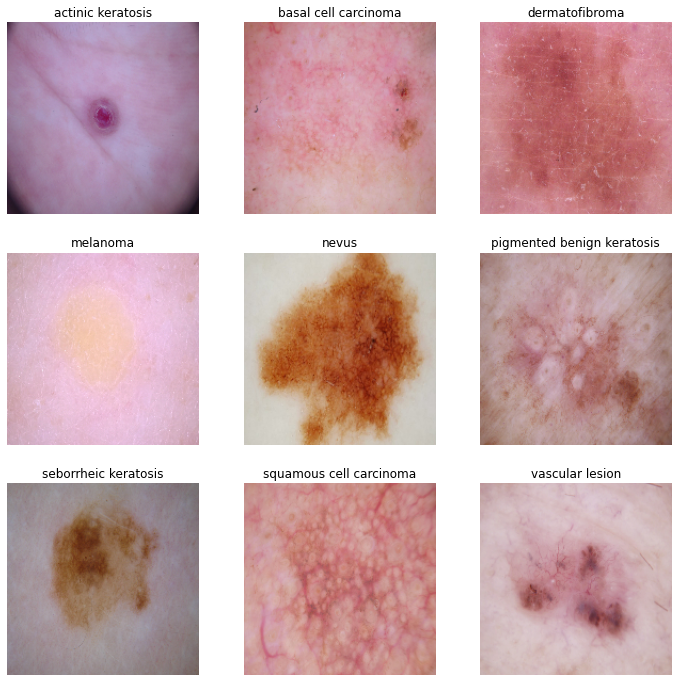

In [9]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

image_count=0
viewed_image = []

plt.figure(figsize=(12,12))
for images, labels in train_ds:
    for l in labels:
        class_number = np.argmax(l)
        image_name = class_names[class_number]
        if image_name not in viewed_image:
            ax = plt.subplot(3, 3, class_number + 1)
            plt.imshow(images[class_number].numpy().astype("uint8"))
            plt.title(image_name)
            plt.axis("off")
            image_count += 1

            viewed_image.append(image_name)
        
        if image_count == 10: break


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

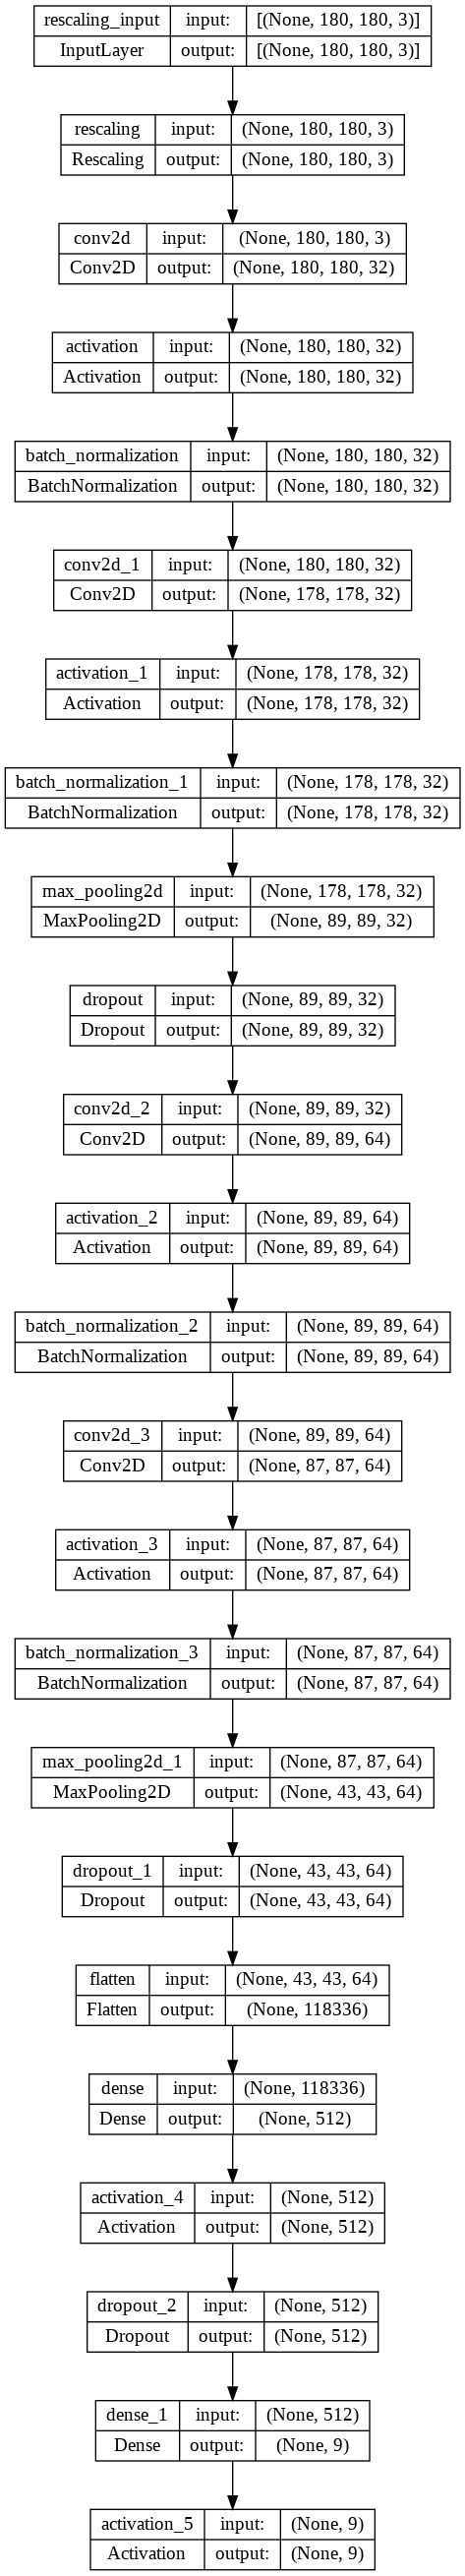

In [11]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling

def make_model(input_shape, num_classes):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

model = make_model(input_shape=image_size + (3,), num_classes=9)
keras.utils.plot_model(model, show_shapes=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 178, 178, 32)      0         
                                                        

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 231ms/step - loss: 41.2771 - accuracy: 0.3030 - val_loss: 22.3376 - val_accuracy: 0.1812
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 4.5036 - accuracy: 0.2494 - val_loss: 64.1028 - val_accuracy: 0.0403
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 2.0863 - accuracy: 0.3092 - val_loss: 51.1091 - val_accuracy: 0.0403
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.9631 - accuracy: 0.3449 - val_loss: 45.1891 - val_accuracy: 0.0447
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8939 - accuracy: 0.3488 - val_loss: 43.8142 - val_accuracy: 0.0805
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8017 - accuracy: 0.3655 - val_loss: 46.2601 - val_accuracy: 0.1544
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8131 - accuracy: 0.3694 - val_loss: 41.0600 - val_accuracy: 0.2013
Epo

### Visualizing training results

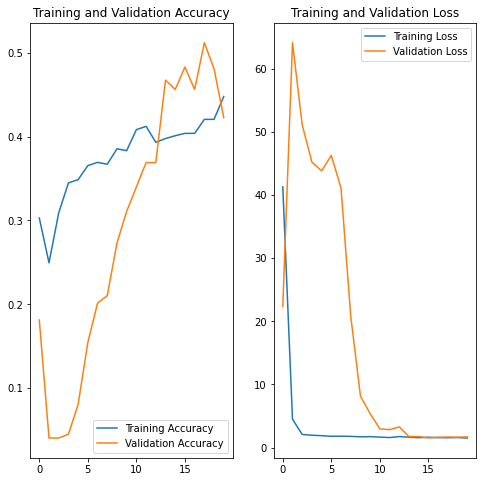

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

`Both the train and validation accuracy are very low with train at 44.8% and validation at 42.3%. The model is currently underfitting. To address this, we would be increasing the number of channels and also add in L2 regularizer which would avoid overfitting due to large number of channels.`

### Todo:
### Create the model, compile and train the model


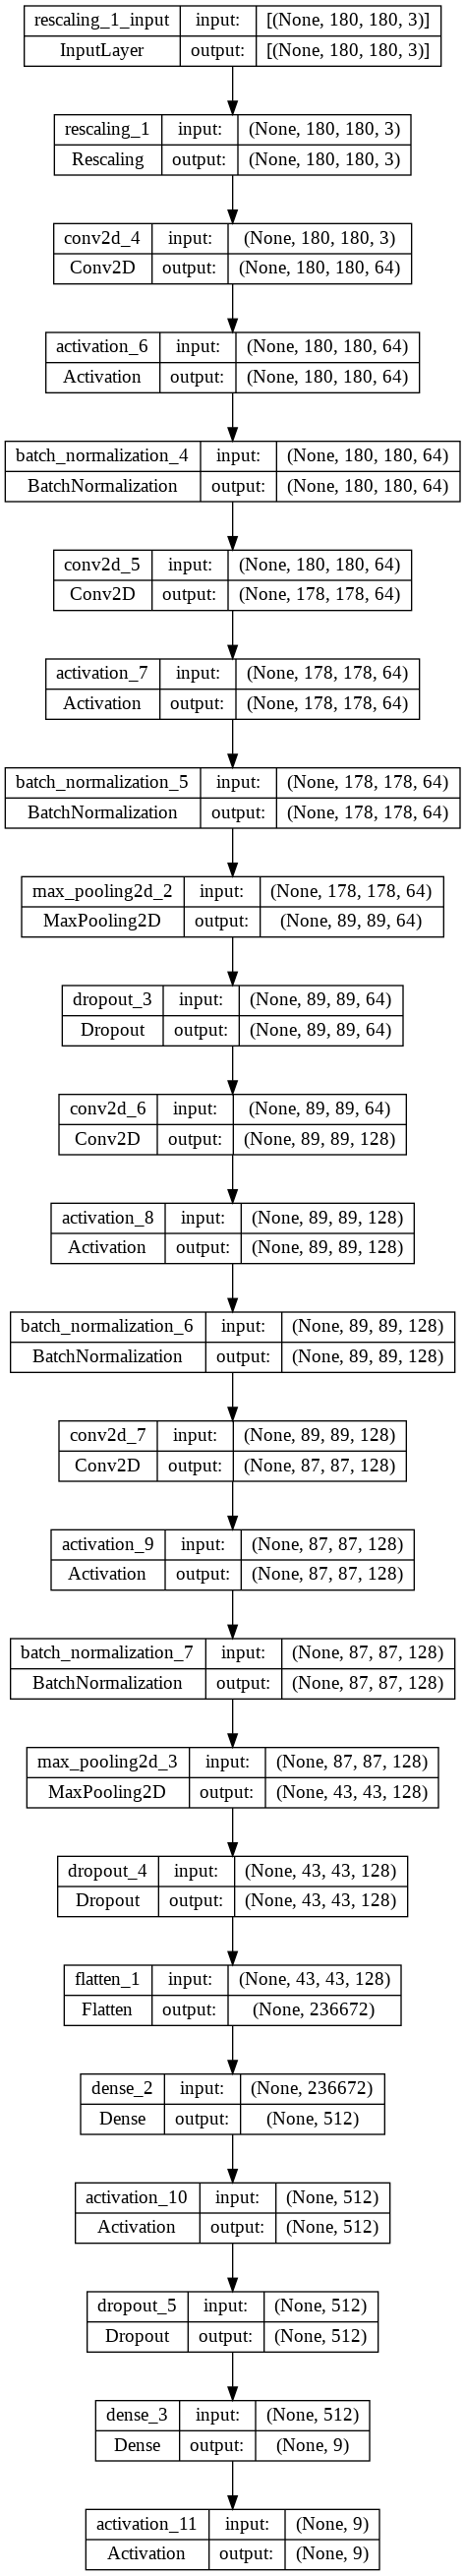

In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.regularizers import l2

def make_model(input_shape, num_classes):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

model = make_model(input_shape=image_size + (3,), num_classes=9)
keras.utils.plot_model(model, show_shapes=True)


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='sgd',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 activation_6 (Activation)   (None, 180, 180, 64)      0         
                                                                 
 batch_normalization_4 (Batc  (None, 180, 180, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 64)      36928     
                                                                 
 activation_7 (Activation)   (None, 178, 178, 64)      0         
                                                      

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 66ms/step - loss: 27.6694 - accuracy: 0.2210 - val_loss: 18.2859 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 3s 45ms/step - loss: 12.6558 - accuracy: 0.3192 - val_loss: 17.6958 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 12.0190 - accuracy: 0.3733 - val_loss: 14.3938 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 11.5738 - accuracy: 0.4308 - val_loss: 15.0357 - val_accuracy: 0.1767
Epoch 5/20
56/56 [==============================] - 3s 46ms/step - loss: 11.3175 - accuracy: 0.4693 - val_loss: 13.7068 - val_accuracy: 0.2215
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 10.9237 - accuracy: 0.5190 - val_loss: 12.5293 - val_accuracy: 0.3400
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 10.6101 - accuracy: 0.5391 - val_loss: 12.0438 - val_accuracy: 0.3579

### Visualizing the results

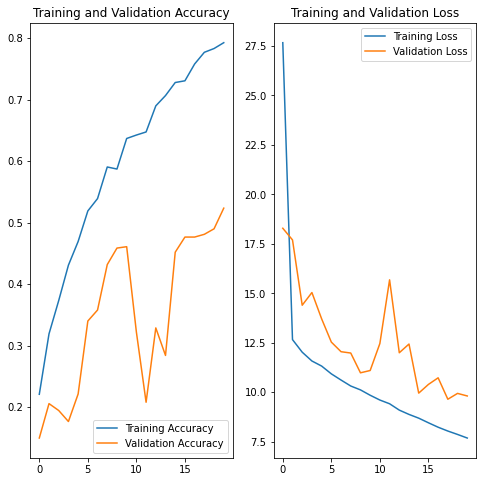

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

`Increasing the number of channels improved the accuracy of training data to ~79.2% and validation accuracy to 52.4%. Though the accuracy has increased for the train set, there is a huge gap between train and validation which might be the result of low sample in the training data causing the model to mug up the patterns and thus resulting in overfitting.`

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
count_dict = dict({cn:0 for cn in class_names})

for images, labels in train_ds:
    for l in labels:
        c_name = class_names[np.argmax(l)]
        count_dict[c_name] += 1

df = pd.DataFrame(count_dict, index=[0])
df = df.T
res = df.div(df.sum(axis=0), axis=1) * 100
res = res.sort_values(by=0, ascending=False)
res


,0
pigmented benign keratosis,20.647321
melanoma,19.642857
basal cell carcinoma,17.243304
nevus,15.457589
squamous cell carcinoma,7.924107
vascular lesion,6.417411
actinic keratosis,5.133929
dermatofibroma,4.296875
seborrheic keratosis,3.236607


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


`seborrheic keratosis represents only 3.24% of the total sample and is the lowest among all the classes.`
`pigmented benign keratosis dominates the class distribution as it represents 20.64% of the total train samples.`

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [24]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [25]:
import Augmentor

In [26]:
path_to_training_dataset='/content/gdrive/MyDrive/Datasets/Train/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9777555750>: 100%|██████████| 500/500 [00:04<00:00, 110.24 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9777494790>: 100%|██████████| 500/500 [00:05<00:00, 98.08 Samples/s] 


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9777472110>: 100%|██████████| 500/500 [00:05<00:00, 97.30 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2126x2185 at 0x7F97739A4A10>: 100%|██████████| 500/500 [00:15<00:00, 31.81 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=964x672 at 0x7F9773A550D0>: 100%|██████████| 500/500 [00:13<00:00, 37.43 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9773A55A50>: 100%|██████████| 500/500 [00:04<00:00, 113.08 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9773A45F10>: 100%|██████████| 500/500 [00:08<00:00, 61.23 Samples/s] 


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9777513790>: 100%|██████████| 500/500 [00:04<00:00, 117.75 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Datasets/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F977816F710>: 100%|██████████| 500/500 [00:04<00:00, 108.57 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027650.jpg_8f936881-7317-4db1-aafc-894231b3f7c6.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_0ab60341-404d-4dd8-b35e-c446707304e6.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_6ceea54f-6301-463b-8568-a912e0243c9a.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_ff1919ed-cd40-42a7-86c5-8708036f7cae.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_198d81c8-deab-4971-bb64-f5773c0bf8e5.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026765.jpg_305a4956-c57e-40d9-b060-68eafabcb87c.jpg',
 '/content/gdrive/MyDrive/Datasets/Train/actinic keratosis/output/actinic keratosi

In [29]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [30]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [31]:
path_list_train = [x for x in glob(os.path.join(data_dir_train, '*.jpg'))]
lesion_list_train = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*.jpg'))]
dataframe_dict_train = dict(zip(path_list_train, lesion_list_train))
path_list_train

[]

In [32]:
import tensorflow_datasets as tfds

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df_train = pd.DataFrame(list(dataframe_dict_train.items()),columns = ['Path','Label'])

new_df = df_train.append(df2)

In [33]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/content/gdrive/MyDrive/Datasets/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  labels='inferred',
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size, 
  label_mode='categorical')

train_ds

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  labels='inferred',
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

val_ds

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>

#### **Todo:** Create your model (make sure to include normalization)

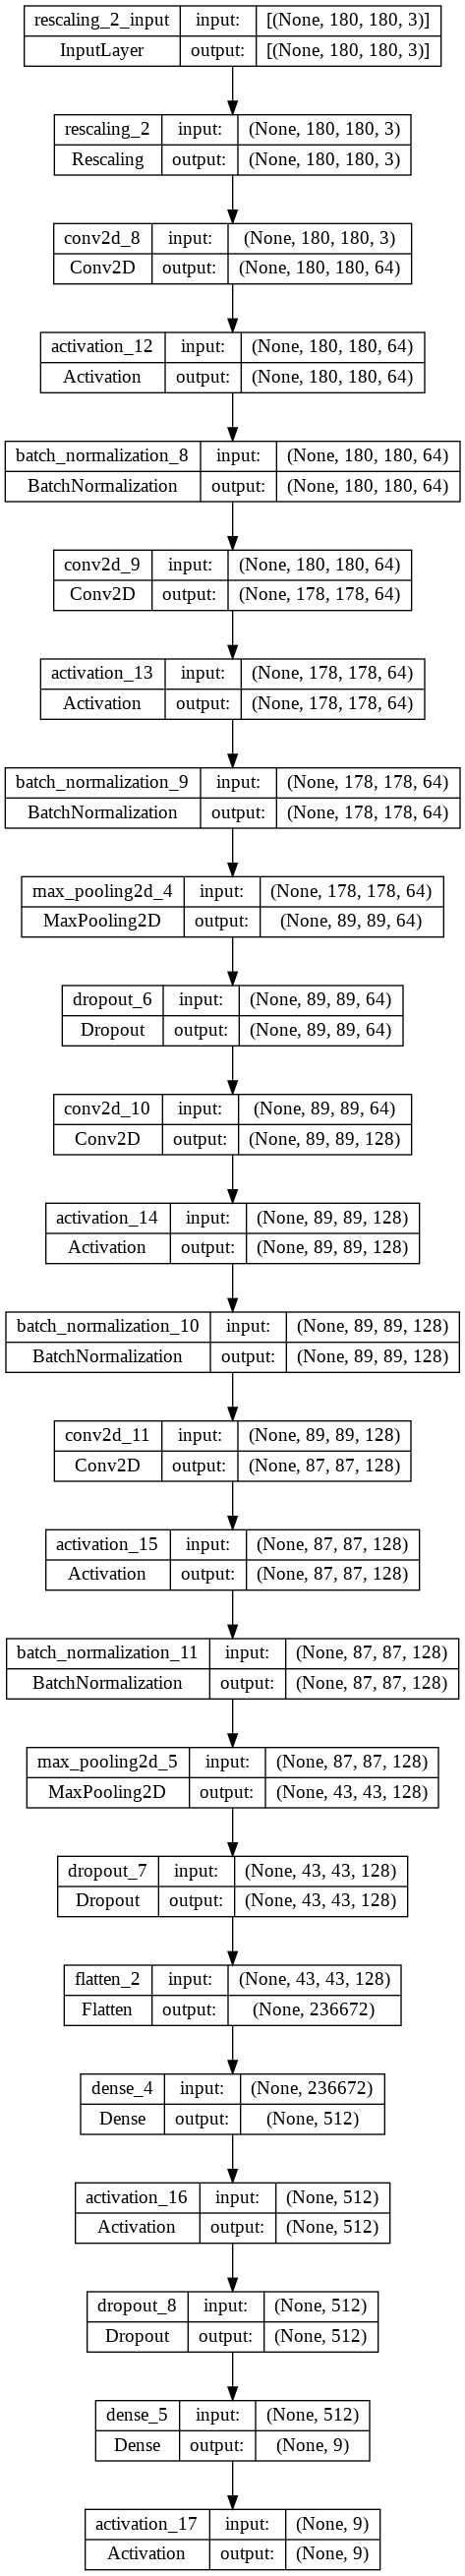

In [37]:
def make_model(input_shape, num_classes):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    return model

model = make_model(input_shape=image_size + (3,), num_classes=9)
keras.utils.plot_model(model, show_shapes=True)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## Your code goes here
model.compile(optimizer='sgd',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [39]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 activation_12 (Activation)  (None, 180, 180, 64)      0         
                                                                 
 batch_normalization_8 (Batc  (None, 180, 180, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 64)      36928     
                                                                 
 activation_13 (Activation)  (None, 178, 178, 64)      0         
                                                      

#### **Todo:**  Train your model

In [40]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 13s 67ms/step - loss: 18.2759 - accuracy: 0.2357 - val_loss: 16.9587 - val_accuracy: 0.1463
Epoch 2/50
169/169 [==============================] - 11s 61ms/step - loss: 11.6331 - accuracy: 0.3444 - val_loss: 12.0023 - val_accuracy: 0.3563
Epoch 3/50
169/169 [==============================] - 11s 62ms/step - loss: 10.7386 - accuracy: 0.4421 - val_loss: 10.4683 - val_accuracy: 0.4944
Epoch 4/50
169/169 [==============================] - 11s 61ms/step - loss: 10.0123 - accuracy: 0.4989 - val_loss: 9.7013 - val_accuracy: 0.5657
Epoch 5/50
169/169 [==============================] - 11s 61ms/step - loss: 9.3072 - accuracy: 0.5708 - val_loss: 12.6585 - val_accuracy: 0.2212
Epoch 6/50
169/169 [==============================] - 11s 62ms/step - loss: 8.7321 - accuracy: 0.5881 - val_loss: 8.5232 - val_accuracy: 0.5835
Epoch 7/50
169/169 [==============================] - 11s 62ms/step - loss: 8.1126 - accuracy: 0.6447 - val_loss: 8.1694 - val_a

#### **Todo:**  Visualize the model results

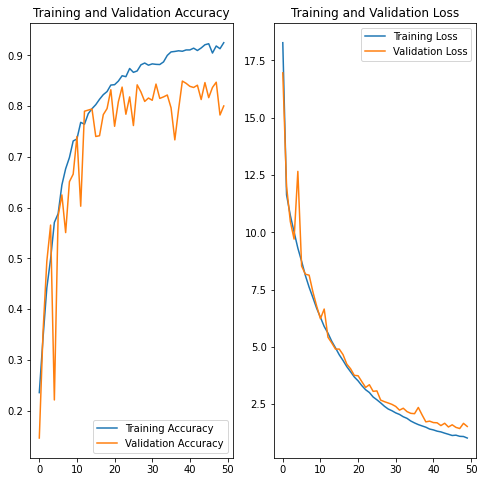

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



`Adding in augmented images reduced the gap between the training and validation numbers while improving the accuracy across both. The train accuracy was increased to 92.5% while the validation accuracy was increased to 80%. Though we did rid of some of the overfitting but increasing the training data to 500 per class, we could probably add in more variations to the images in order to improve the validation accuracy.`